In [2]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt 
import seaborn as sns; sns.set()


# Mini Proyecto MVA

## Aprendizaje Automático Intermedio e Ingeniería de Características

### Abril 2023

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Introducción 

En este notebook vamos a trabajar en el uso de técnicas de aprendizaje automático basadas en análisis multivariante para un problema de **clasificación**.

La aplicación sobre la que vamos a trabajar es el **reconocimiento de caras** usando el conjunto de datos *benchmark* [Labeled Faces in the Wild](https://scikit-learn.org/stable/datasets/real_world.html#labeled-faces-in-the-wild-dataset), que está disponible para trabajar con sklearn. Los datos son imágenes de caras de personajes relevantes capturadas de internet y etiquetadas. 

Concretamente el desarrollo del trabajo en el notebook va a ser el siguiente. 

1. Partimos de un modelo de clasificación en el espacio original, es decir, usando como observaciones los arrays que contienen los valores de escala de gris de los píxeles de las imágenes. Para este modelo exploraremos la máquina de vectores soporte lineal o su versión no lineal con kernel rbf.


2. Propondremos 3 métodos de extracción de características basados en análisis multivariante:
    - PCA
    - LDA
    - KPCA
    Estos métodos nos proporcionarán un espacio intermedio con el que se alimenta el clasificador final. Como clasificadores finales usaremos SVMs no lineales y LDA.


3. Evaluaremos el impacto de usar una extracción de características previa a la etapa de clasificación.


4. Repetiremos el experimento contaminando los datos de entrenamiento con ruido para ver la robustez de los métodos de extracción de características a la hora de trabajar en presencia de datos contaminados con ruido.

# 1. Carga de los datos y generación de las particiones de entrenamiento y test

La siguiente celda carga los datos. Usaremos solo las imágenes de los sujetos que tienen al menos 50 ejemplos. 

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
print("Nombre de los sujetos en la base")
print(faces.target_names)
print("")
print("dimensiones: \n número de fotos x filas x columnas")
print(faces.images.shape)

Nombre de los sujetos en la base
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

dimensiones: 
 número de fotos x filas x columnas
(1560, 62, 47)


Representamos alguna foto del conjunto

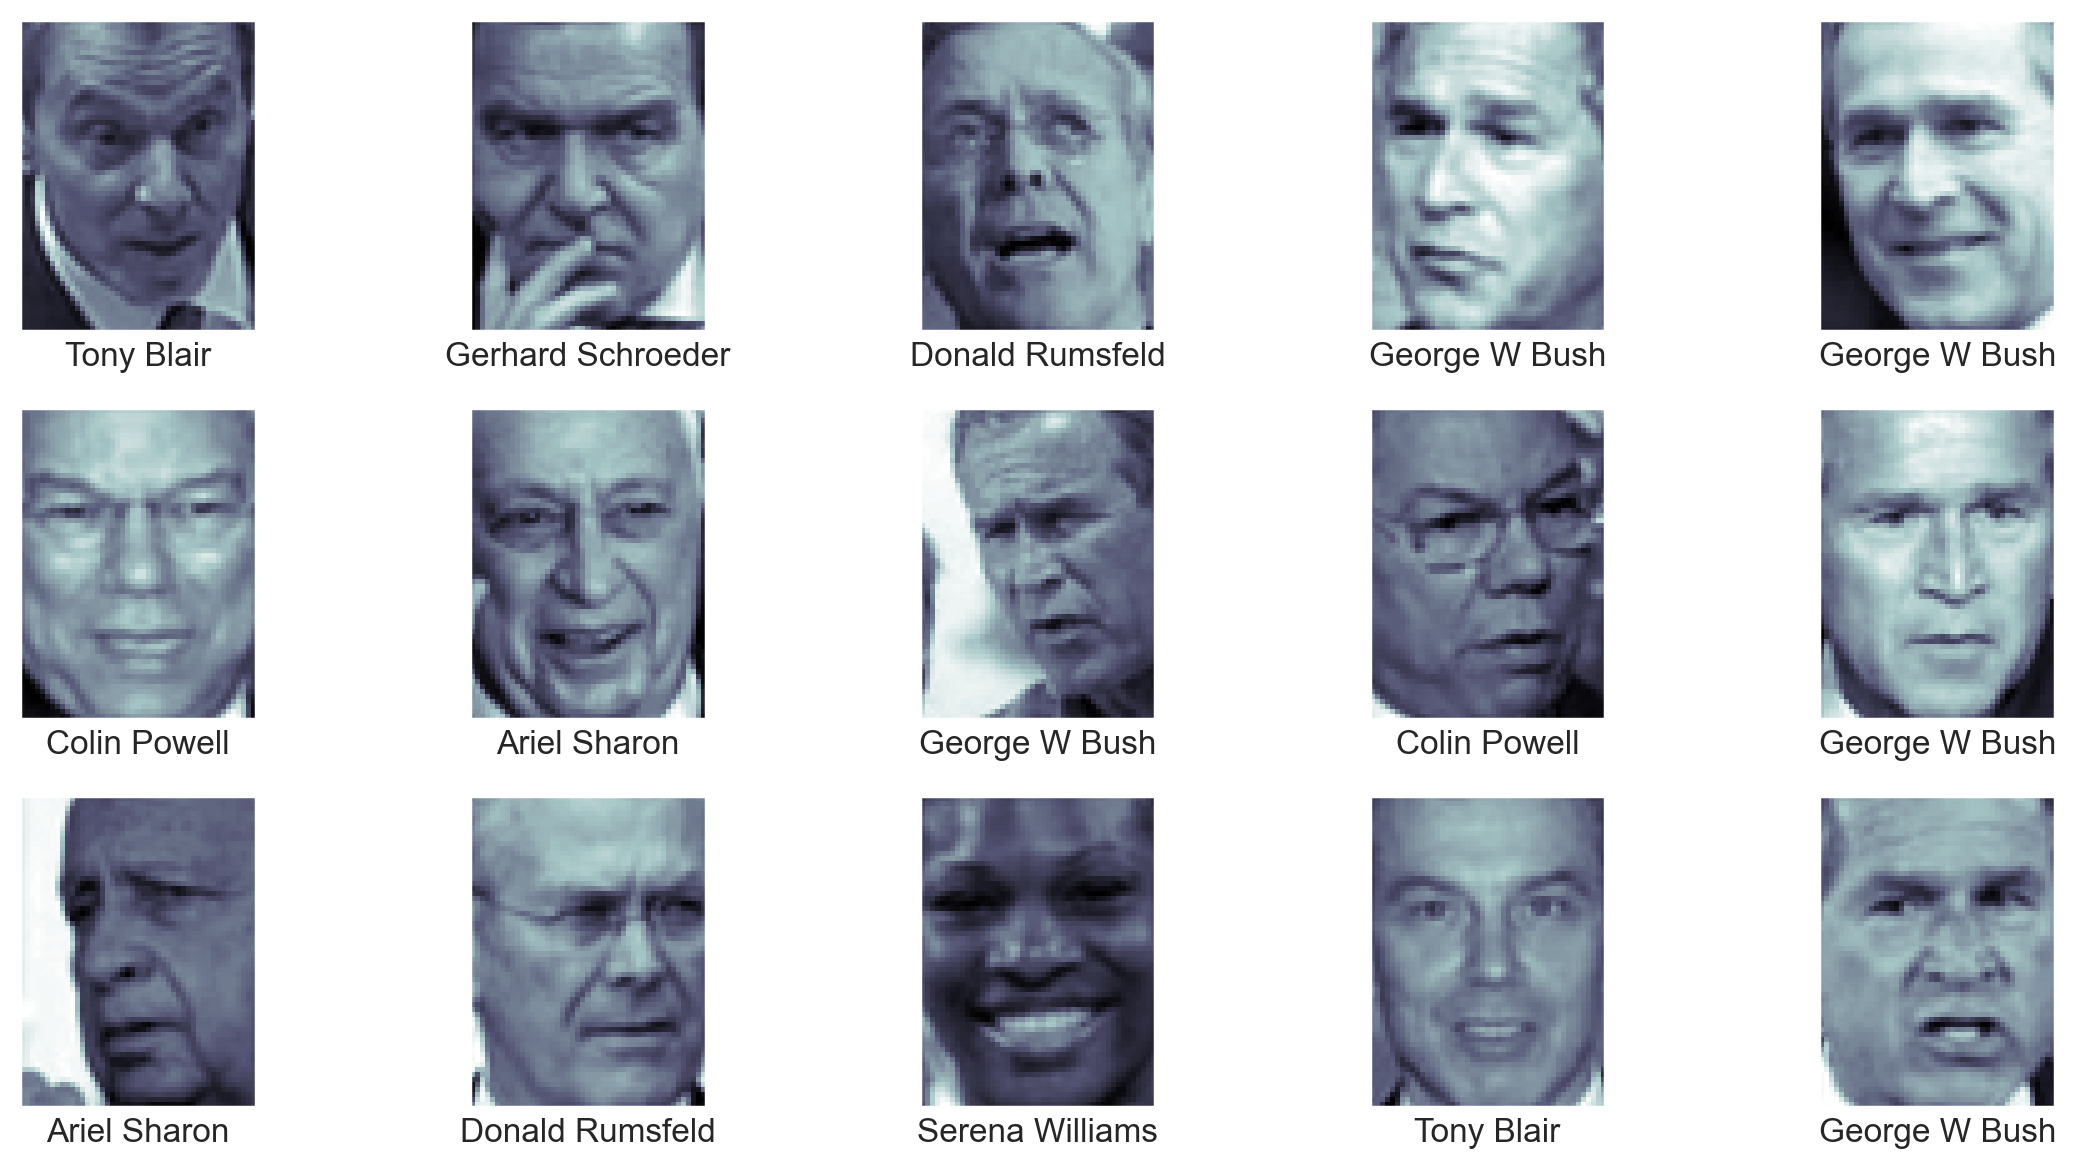

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
fig.tight_layout()

Finalmente separamos el 40% de las fotos para conjunto de test


In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                test_size=0.4,
                                                random_state=42, stratify = faces.target)


# 2. Clasificación con SVM (10%)


## 2.1. Entrenamiento de la SVM
Realice una primera clasificación con SVM usando como entradas directamente las imágenes originales. Evalúe como rangos para los hiperparámetros:
- `C`: 0.01, 0.1, 1, 10, 100, 1000
- `kernel`:
    - `rbf`: valores para `gamma`: 1e-9, 1e-8, 1e-7, 1e-6, 1e-5
    - `linear`

Para ahorrar tiempo de cómputo vamos a emplear únicamente 3 folds en la validación cruzada y a fijar el argumento `n_jobs` a `-1`

In [7]:
##################
# YOUR CODE 
##################
from sklearn.model_selection import GridSearchCV
from sklearn import svm

v_C = [0.01, 0.1, 1, 10, 100, 1000]
v_gamma = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
svm_params = [{'kernel':['linear']
              ,'C':v_C
             }
              ,{'kernel':['rbf']
              ,'C':v_C
              ,'gamma' : v_gamma
             }]

grid_svm = GridSearchCV(svm.SVC(), param_grid=svm_params, cv=3, verbose=2, n_jobs=-1)
grid_svm.fit(Xtrain, ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
                          'kernel': ['rbf']}],
             verbose=2)

**Imprimid la mejor configuración de parámetros para la SVM y el acierto de clasificación en el conjunto de test para esa configuración.**

In [9]:
##################
# YOUR CODE 
##################
print("Score con data de entrenamiento R^2={0:.4f}".format(grid_svm.score(Xtrain, ytrain)))
print("Score with the test data R^2={0:.4f}".format(grid_svm.score(Xtest, ytest)))
print("Hyperparameters escogidos con cross-validation")
print(grid_svm.best_params_)

Score con data de entrenamiento R^2=0.9915
Score with the test data R^2=0.7933
Hyperparameters escogidos con cross-validation
{'C': 0.1, 'kernel': 'linear'}


**Almancenad las predicciones para el conjunto de test en un array que se llame** `y_pred_test_svm`

In [10]:
##################
# YOUR CODE 
##################
y_pred_test_svm = grid_svm.predict(Xtest)

La siguiente celda representa algunas de las imágenes del conjunto de test. Si la clasificación ha sido incorrecta la etiqueta sale en rojo.

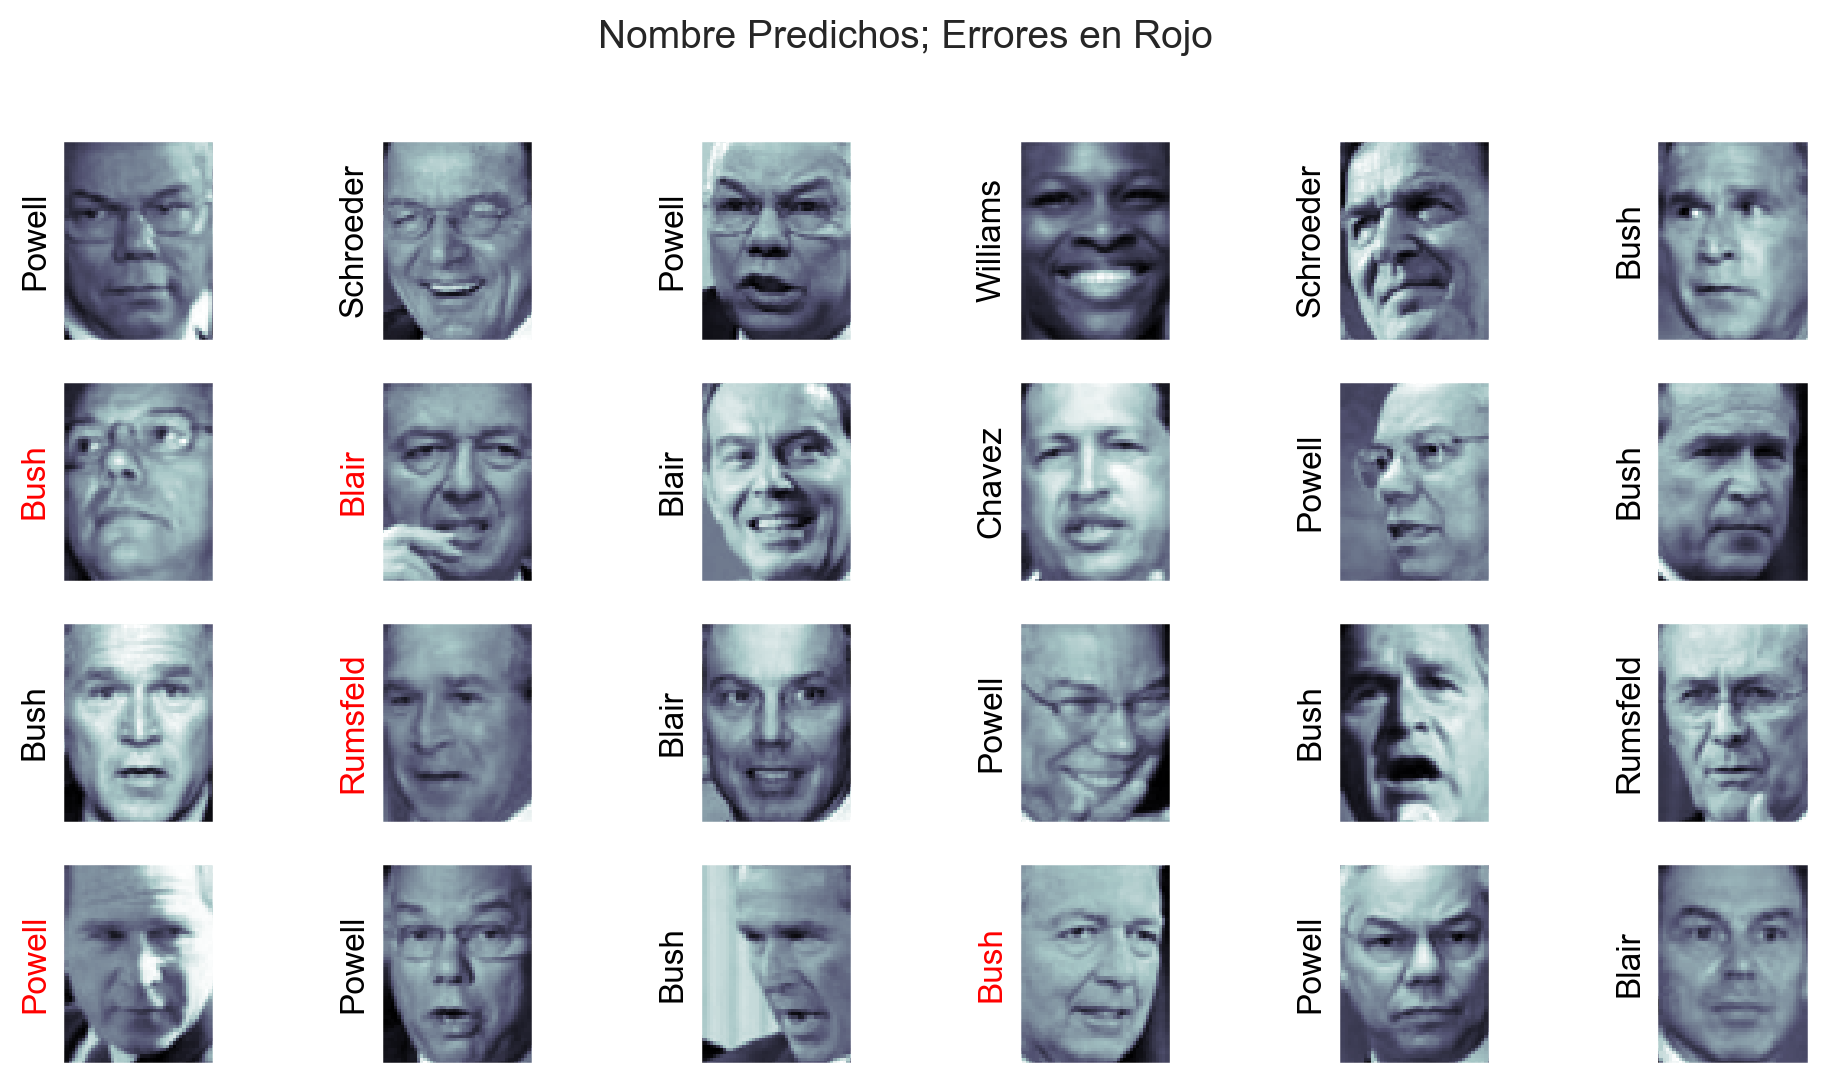

In [11]:
fig, ax = plt.subplots(4, 6, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred_test_svm[i]].split()[-1],
                   color='black' if y_pred_test_svm[i] == ytest[i] else 'red')
fig.suptitle('Nombre Predichos; Errores en Rojo', size=14);

## 2.2. Matriz de confusión

En un problema multiclase como el caso de estudio, la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) da una idea más detallada sobre la calidad de las clasificaciones para cada una de las clases en juego. La siguiente celda representa esta matriz de confusión para la SVM

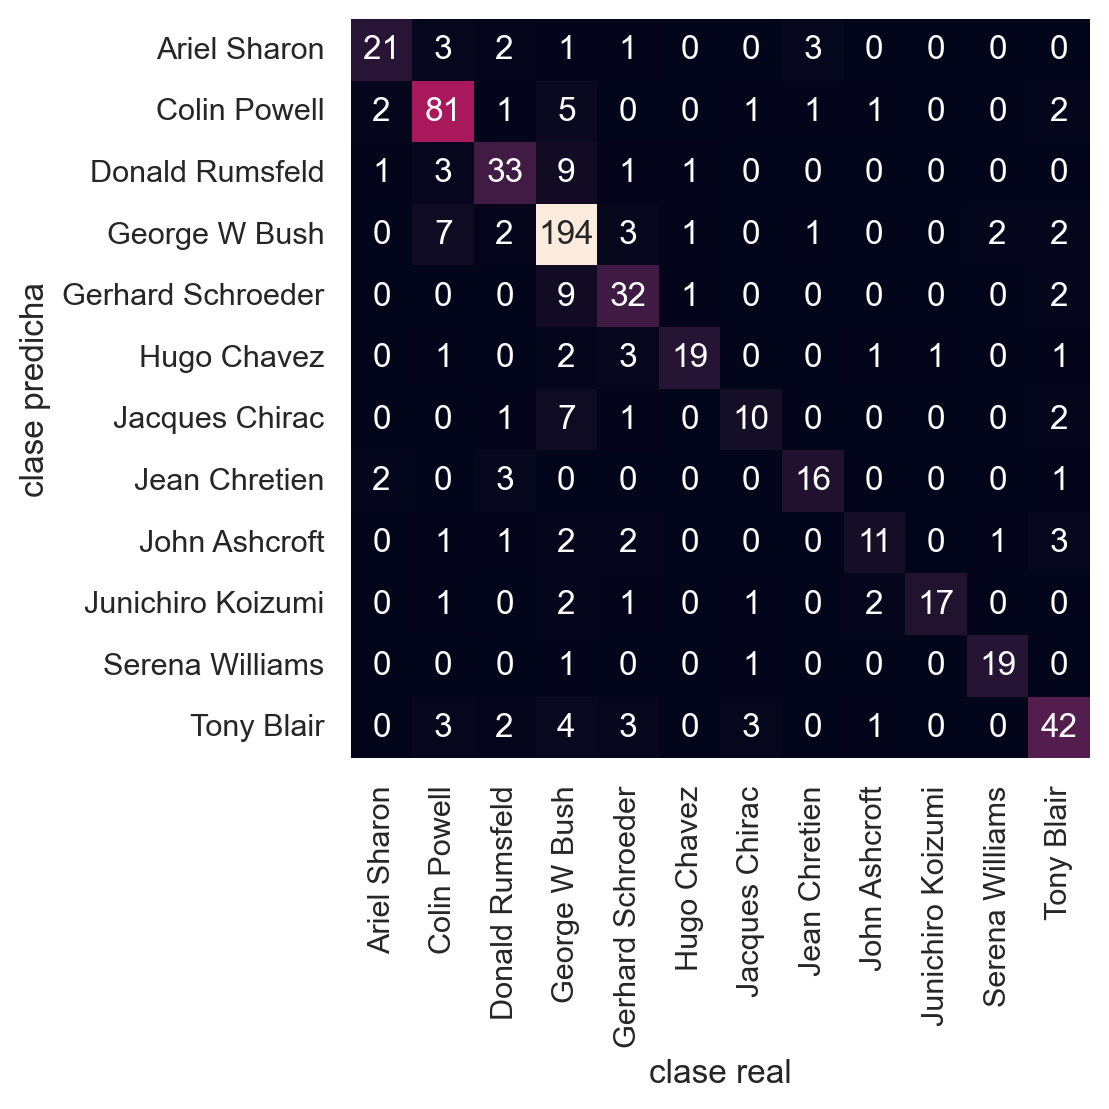

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
mat_conf = metrics.confusion_matrix(y_pred_test_svm, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

# 3. Generación de subespacios mediante extracción de características lineal (20%)

Vamos a emplear las siguientes técnicas para generar subespacios alternativos al espacio original:

1. PCA con 500 componentes principales
2. Linear Discriminant Analysis con el número máximo de componentes que se puedan extraer en este problema

Para cada uno de estos métodos:
- Entrenad el generador del subespacio con el array `Xtrain`
- Transformad tanto los datos de entrenamiento como los de test:
    1. Para el PCA generad los arrays `Xtrain_pca` y `Xtest_pca` resultantes de transformar el conjunto de entrenamiento y el de test con el PCA.
    2. Para el LDA generad los arrays análogos `Xtrain_lda` y `Xtest_lda` 

In [22]:
##################
# YOUR CODE 
##################
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=500).fit(Xtrain, ytrain)
Xtrain_pca = pca.transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

lda = LinearDiscriminantAnalysis().fit(Xtrain, ytrain)
Xtrain_lda = lda.transform(Xtrain)
Xtest_lda = lda.transform(Xtest)

Para el PCA representad la varianza capturada a medida que aumenta el número de componentes principales

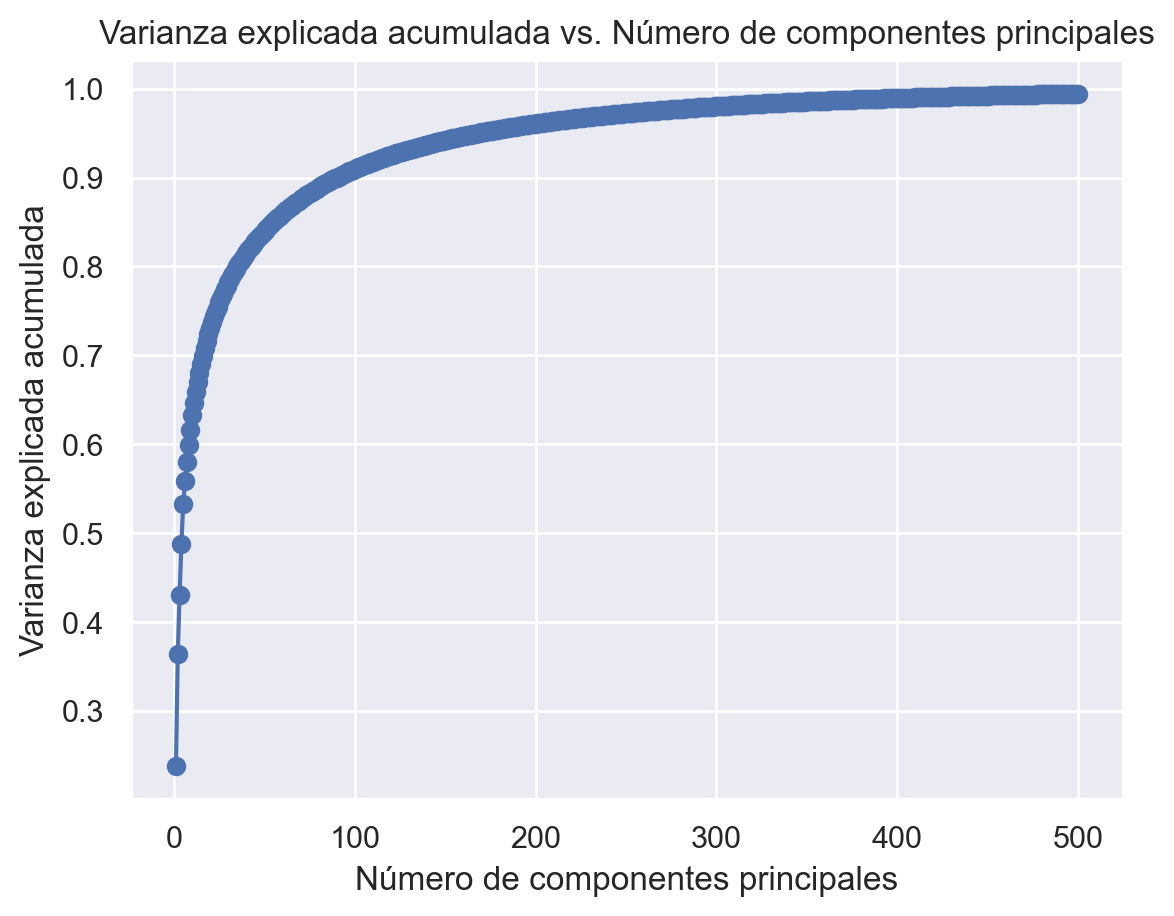

In [26]:
##################
# YOUR CODE 
##################
variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(variance_ratio_cumulative) + 1), variance_ratio_cumulative, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs. Número de componentes principales')
plt.show()

Representad las 15 primeras componentes principales apoyándoos en el código de la siguiente celda, discutid si alguna de las componentes principales (se llaman eigenfaces en jerga de reconocimiento de caras) se parece a alguna de las caras de los personajes del conjunto de datos

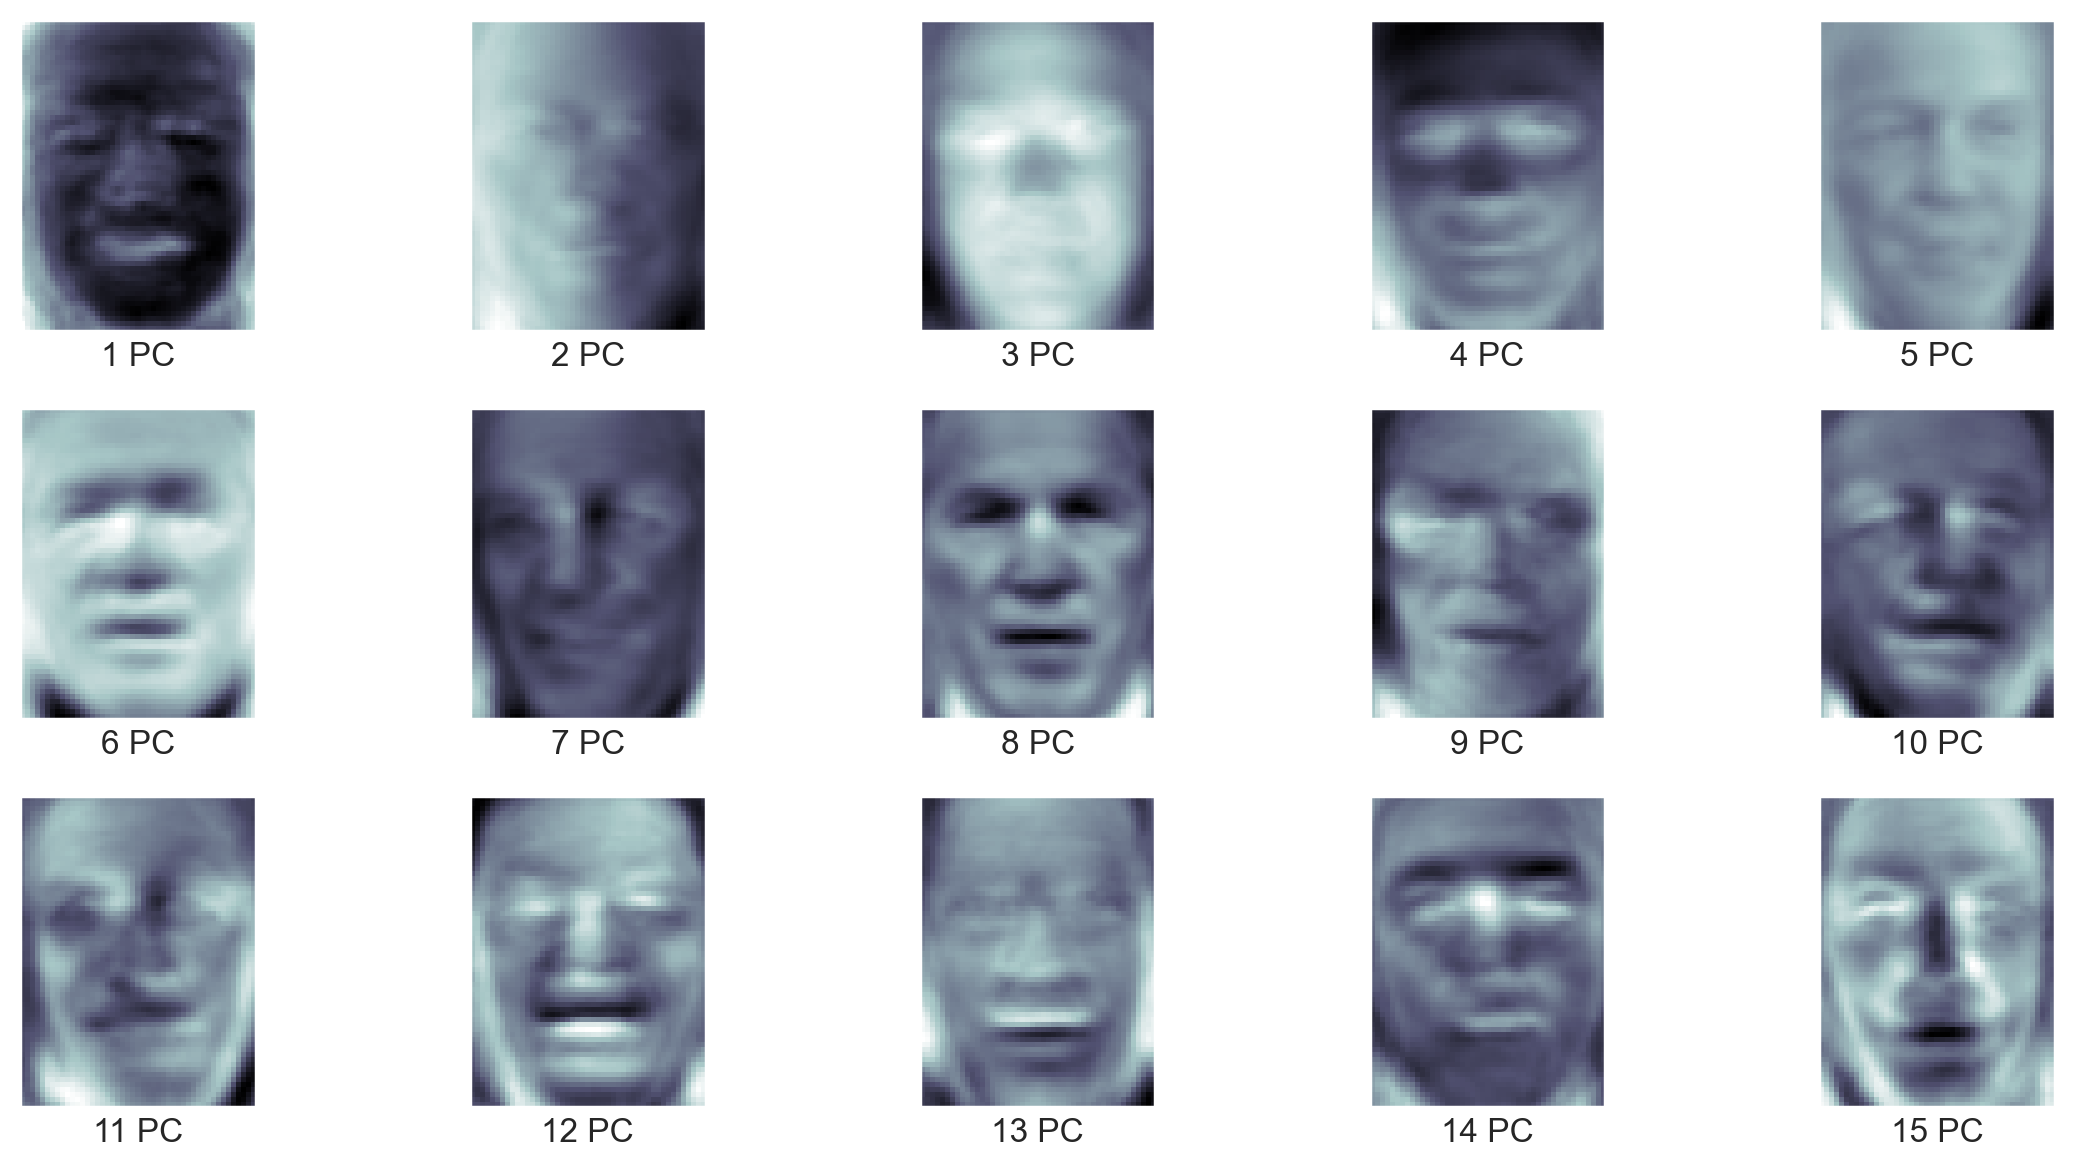

In [30]:
componentes_principales = pca.components_
XXX =componentes_principales[:15] # sacad las componentes principales del objeto PCA

fig, ax = plt.subplots(3, 5, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(XXX[i].reshape(62,47), cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel="{0:d} PC".format(i+1))
fig.tight_layout()

Repetid el plot de la varianza capturada a medida que aumenta el número de componentes para LDA. 

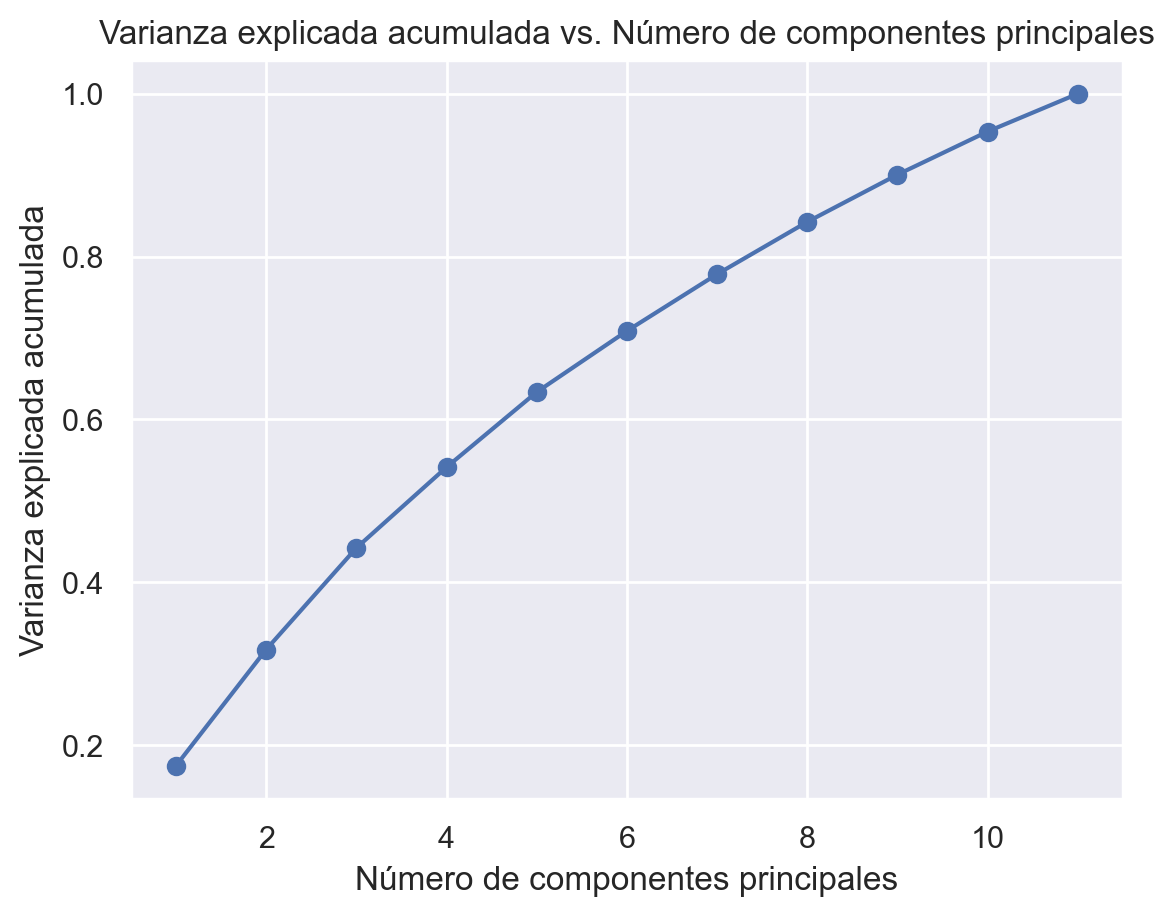

In [31]:
##################
# YOUR CODE 
##################
variance_ratio_cumulative = np.cumsum(lda.explained_variance_ratio_)
plt.plot(range(1, len(variance_ratio_cumulative) + 1), variance_ratio_cumulative, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs. Número de componentes principales')
plt.show()

Representad las componentes obtenidas con LDA (están en el atributo `scalings_` del objeto `LinearDiscriminantAnalysis` ya entrenado. Discutid las diferencias con las eigenfaces que habéis representado para PCA.

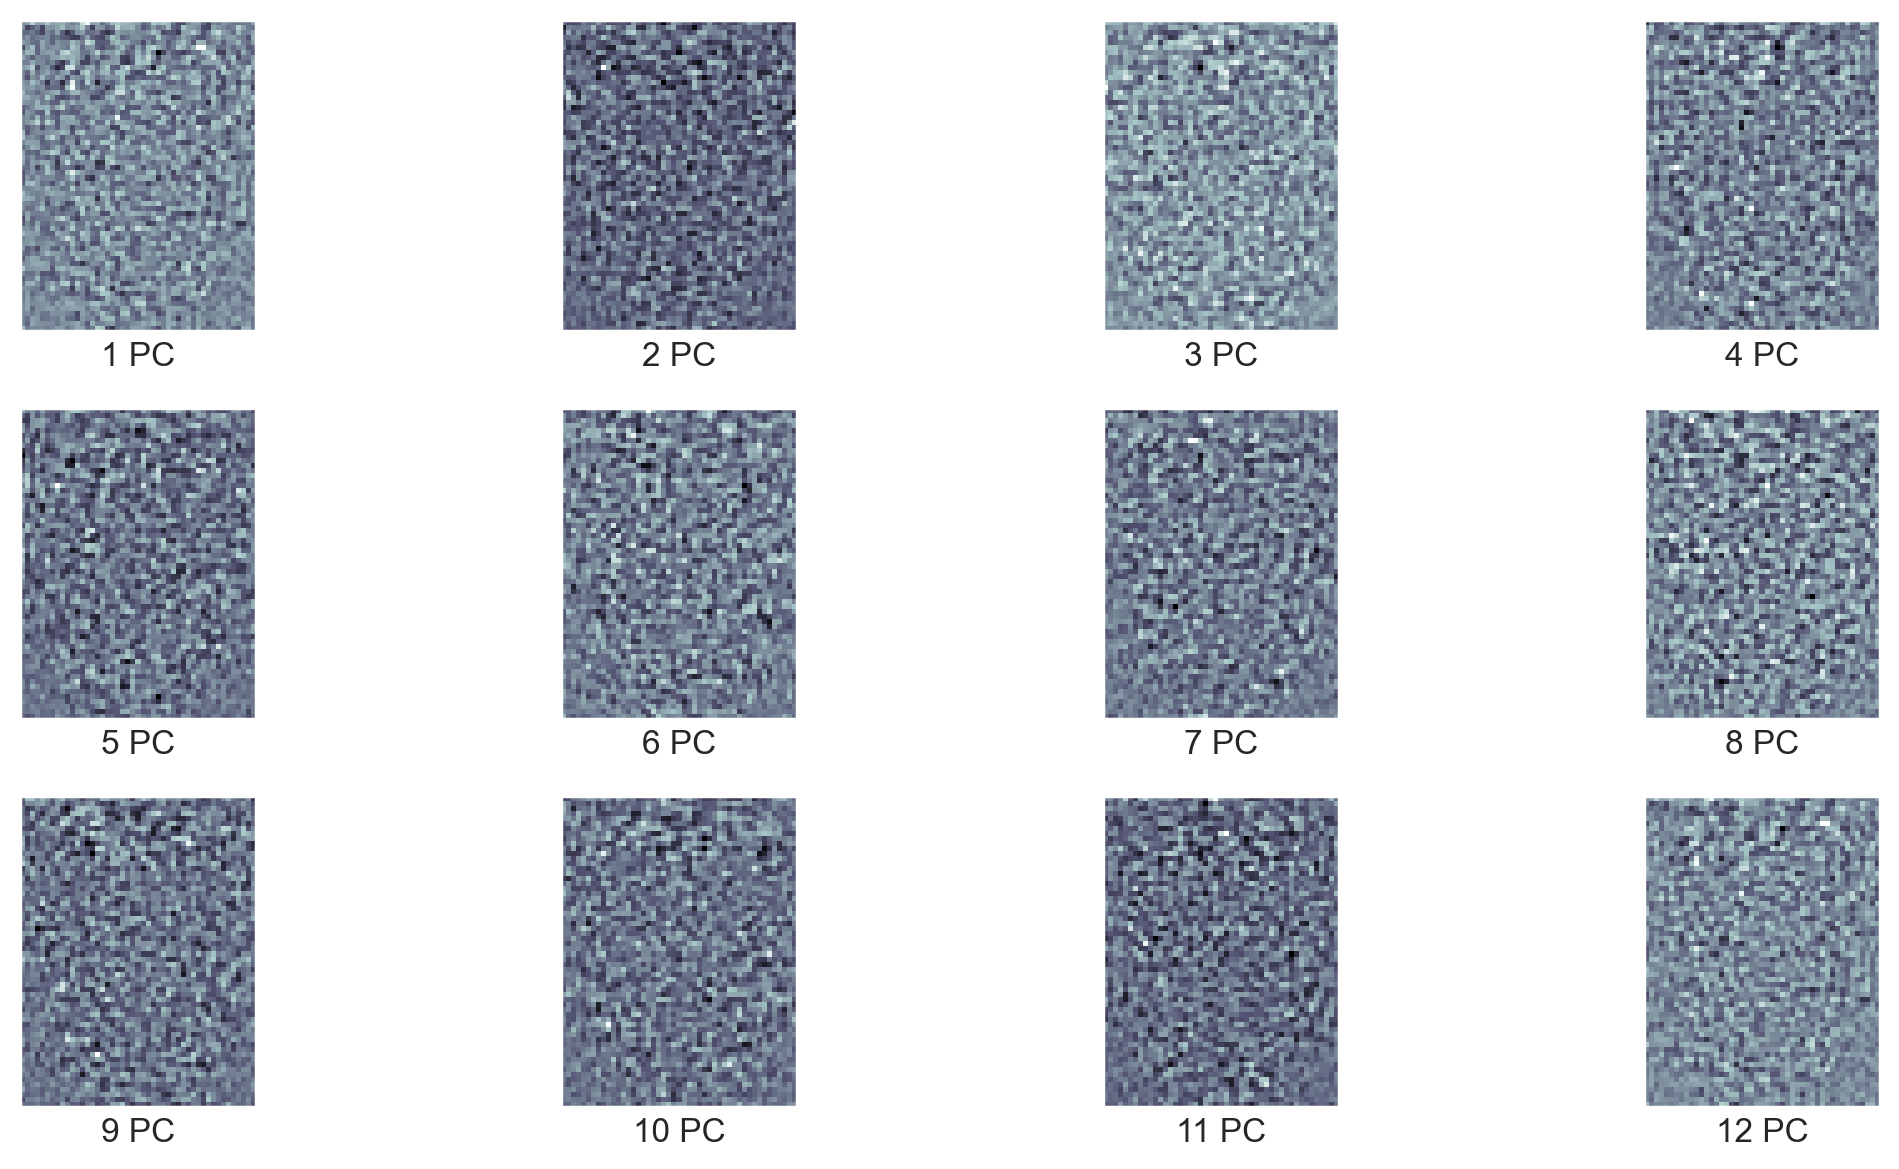

In [35]:
XXX =  lda.scalings_# sacad las componentes  del objeto LinearDiscriminantAnalysis

fig, ax = plt.subplots(3, 4, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(XXX[:,i-1].reshape(62,47), cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel="{0:d} PC".format(i+1))
fig.tight_layout()

# 4. Transformer que seleccione un número determinado de columnas (5%)

Los clasificadores que se apoyen en un subespacio obtenido mediante extracción de características se van a construir mediante una [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) donde la primera etapa será la extracción de características seguida del clasificador.


La razón de usar estas pipelines es poder emplear validación cruzada para elegir el número óptimo de componentes principales que se extraen.

Por ejemplo, supongamos que queremos entrenar una SVM con las 30 primeras componentes principales, el pipeline original debería hacer lo siguiente:

- Etapa 1: PCA que seleccione 30 componentes principales
- Etapa 2: SVM

Este pipeline se debe entrenar usando `Xtrain` como argumento y evaluar usando `Xtest` como argumento. Ahora bien, si queremos aprender el número óptimo de componentes principales y los parámetros óptimos de la SVM usando validación cruzada, el pipeline **ejecutaría** un PCA para cada combinación de hiperparámetros de la SVM. Esto es ineficiente porque las componentes principales que resultarían de ir llamando a PCA con un número creciente de componentes principales son exactamente las mismas que se obtendrían si se llama a PCA usando como argumento el número máximo de componentes principales que se contemple en el rango que se recorre con validación cruzada. Por tanto, una solución más eficiente será ejecutar PCA con un número de componentes igual al máximo del rango de validación cruzada **fuera de la validación cruzada** y que la primera etapa del pipeline, en lugar de hacer un PCA sobre los datos originales, simplemente seleccione las columnas correspondientes de los datos transformados por el PCA que se hizo fuera.


Entonces el para construir el pipeline eficiente, vamos a reemplazar la extracción de características por un `transformer` que simplemente seleccione el número de columnas que se necesite.
- Etapa 1: Transformar el array que se ponga a la entrada devolviendo sólo las primeras `n` columnas
- Etapa 2: SVM

Es necesario recordar que este pipeline eficiente **no se usa con los datos originales sino con los datos transformados por el PCA que se entrena fuera**, es decir, usando como argumento `Xtrain_pca` o `Xtest_pca`, según corresponda.

Si en lugar de PCA se usase LDA como extractor de características, la primera etapa del pipeline no cambia, sólo cambiarían los arrays con los que se le llama, `Xtrain_lda` o `Xtest_lda`.

**Complentad el código de las funciones `transform`y `fit_transform` del `Transformer` de la celda siguiente**

In [37]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
class n_first_cols(TransformerMixin,BaseEstimator):
    
    def __init__(self, n_components=1):
        self.n_components = n_components
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, :self.n_components]
        # devuelve las n_components primeras columnas de X
        
    def fit_transform(self, X, y=None):
        return self.transform(X, y) # devuelve las n_components primeras columnas de X
        



# 5. Clasificación con Linear Discriminant Analysis (15%)

Vamos a clasificar las imágenes usando LDA en modo *stand alone*, es decir, alimentando LDA con las imágenes originales, y también como etapa de clasificación en un pipeline donde primero se usa PCA para transformar los datos.

## 5.1. Evaluación de LDA como clasificador *stand alone* 

Obtened el acierto de clasificación en el conjunto de test y la matriz de confusión de un clasificador LDA actuando directamente en el espacio de las imágenes originales.

Score with the test data R^2=0.6683


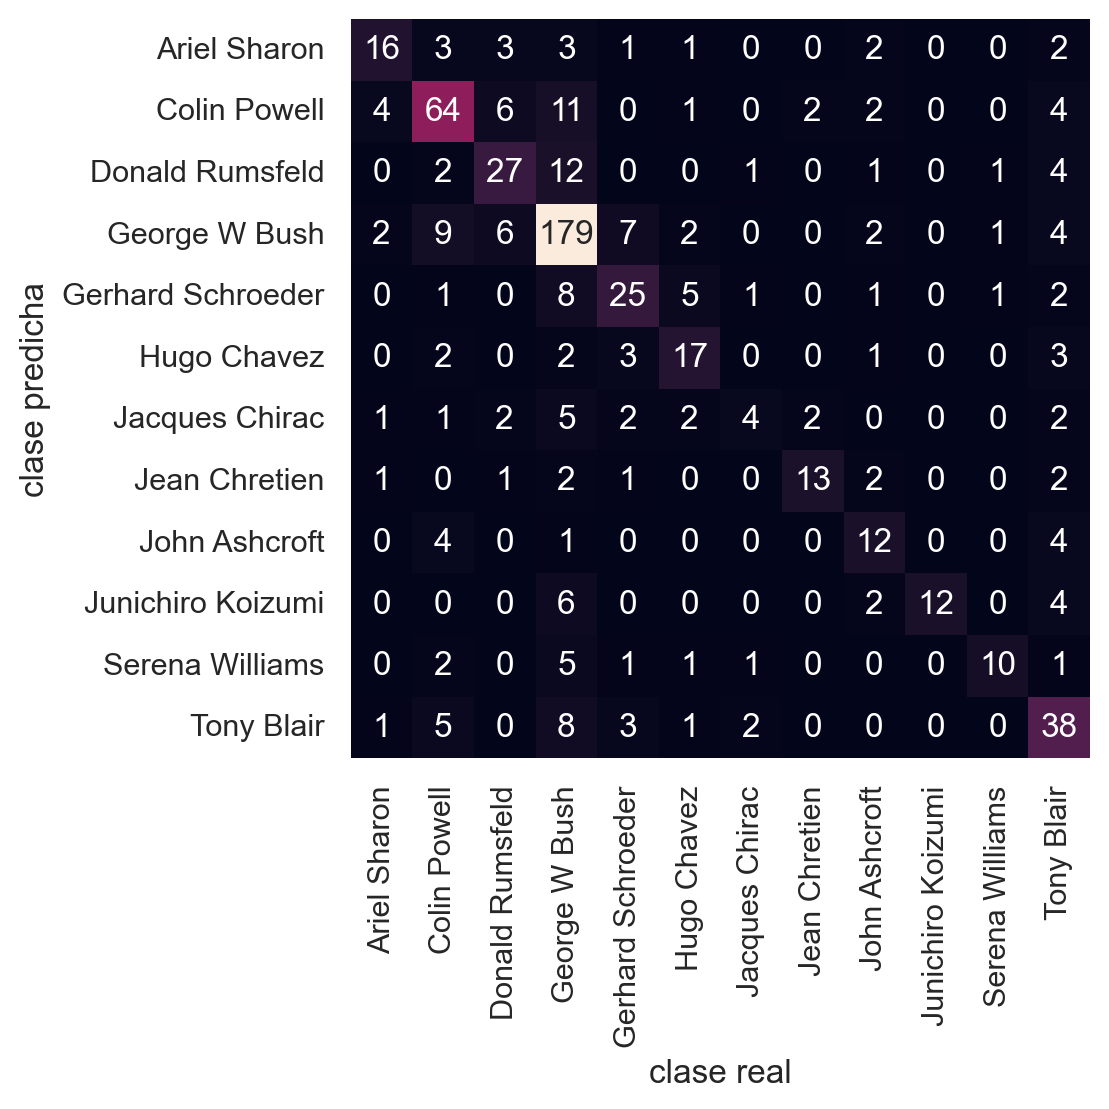

In [36]:
##################
# YOUR CODE 
##################
print("Score with the test data R^2={0:.4f}".format(lda.score(Xtest, ytest)))
y_pred_test_lda = lda.predict(Xtest)
mat_conf = metrics.confusion_matrix(y_pred_test_lda, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

**Discutid que método resulta mejor si LDA o SVM sobre el espacio de las imágenes originales**

## 5.2. PCA + LDA 

Ahora emplearemos el PCA como extractor de características para alimentar al LDA. Para ello 
1. Programad una pipeline que tenga una primera etapa formada por el `transformer` de la sección 4 y una segunda etapa formada por un LDA
2. Obtened mediante validación cruzada el número ideal de columnas que se eligen en la primera etapa. Al menos explorad los valores 50, 100 y 150 para este número ideal de componentes principales.
3. Imprimid el acierto de este clasificador en el conjunto de test y la matriz de confusión

**¿Cuál es el número ideal de componentes principales que mejores resultados proporcionan?**

In [68]:
##################
# YOUR CODE 
##################
from sklearn.pipeline import Pipeline
valores = [50,100,150]
for i in valores :
    pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=i)),
        ('lda', LinearDiscriminantAnalysis())
    ])
    X_transformed = pipeline.fit_transform(Xtrain_pca, ytrain)
    print("Score with the test data R^2={0:.4f}".format(pipeline.score(Xtest_pca, ytest)))

Score with the test data R^2=0.7516
Score with the test data R^2=0.7901
Score with the test data R^2=0.7917


Score with the test data R^2=0.7917


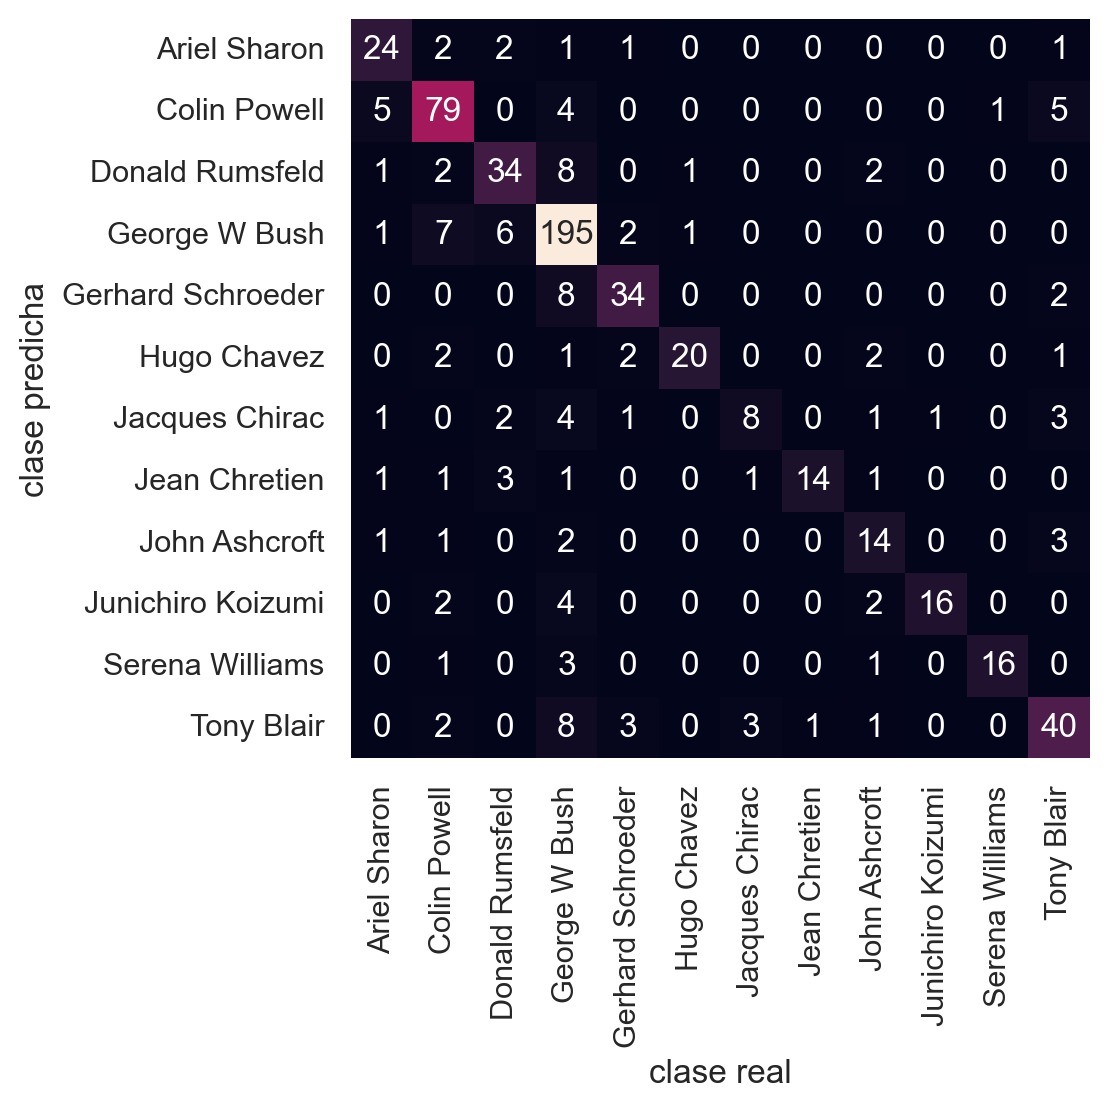

In [69]:
pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=150)),
        ('lda', LinearDiscriminantAnalysis())
    ])
X_transformed = pipeline.fit_transform(Xtrain_pca, ytrain)
print("Score with the test data R^2={0:.4f}".format(pipeline.score(Xtest_pca, ytest)))
y_pred_test_pipeline = pipeline.predict(Xtest_pca)
mat_conf = metrics.confusion_matrix(y_pred_test_pipeline, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

**Discutid el impacto de combinar el PCA con el LDA en el acierto de clasificación y en la separabilidad de las clases**

# 6. Clasificación con SVM (15%)

En esta sección usaremos una SVM no lineal como etapa de clasificación en el pipeline.

## 6.1. PCA + SVM 

Repetid el análisis de punto 5.2 pero usando una SVM en la etapa de clasificación. Vamos a usar una SVM no lineal con kernel RBF. Para los rangos de parámetros **al menos** explorad:
- `gamma`: 1e-9,1e-8,1e-7, 1e-6,
- `C` = 0.1, 1, 10, 100, 1000

In [62]:
##################
# YOUR CODE 
##################
from sklearn.pipeline import Pipeline

valores = [50,100,150]
for i in valores :
    pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=i)),
        ('svm', svm.SVC(kernel='rbf'))
    ])
    param_grid = {
        'svm__gamma': [1e-9, 1e-8, 1e-7, 1e-6],
        'svm__C': [0.1, 1, 10, 100, 1000]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(Xtrain_pca, ytrain)
    print("Score with the test data R^2={0:.4f}".format(grid_search.score(Xtest_pca, ytest)))

Score with the test data R^2=0.4151
Score with the test data R^2=0.4167
Score with the test data R^2=0.4151


**¿Cuál es el número de componentes principales del PCA que se elige por validación cruzada?**

In [66]:
##################
# YOUR CODE 
##################
pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=100)),
        ('svm', svm.SVC(kernel='rbf'))
    ])
param_grid = {
    'svm__gamma': [1e-9, 1e-8, 1e-7, 1e-6],
    'svm__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipeline, param_grid, cv=3)
grid_search.fit(Xtrain_pca, ytrain)
print("Score with the test data R^2={0:.4f}".format(grid_search.score(Xtest_pca, ytest)))

Score with the test data R^2=0.4167


Obtened el acierto de clasificación en el conjunto de test y la matriz de confusión para este clasificador PCA + LDA

Score with the test data R^2=0.4167


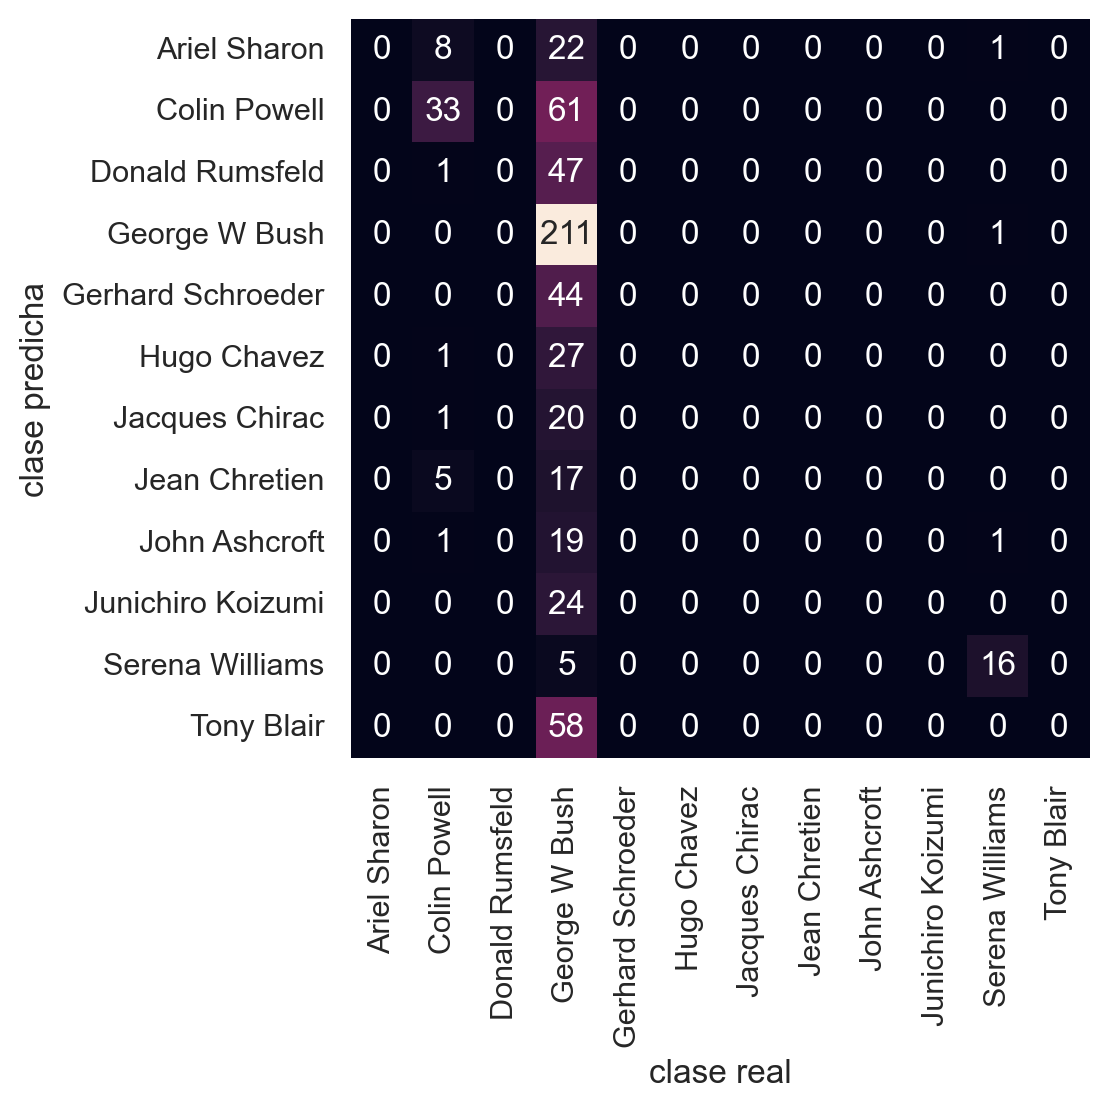

In [67]:
##################
# YOUR CODE 
##################
print("Score with the test data R^2={0:.4f}".format(grid_search.score(Xtest_pca, ytest)))
y_pred_test_pipeline = grid_search.predict(Xtest_pca)
mat_conf = metrics.confusion_matrix(y_pred_test_pipeline, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

## 6.2. LDA + SVM

Ahora vamos a combinar el LDA como extractor de características con la SVM como clasificador final. Recuerde que esta pipeline se debe alimentar con los datos transformados mediante el LDA de la sección 3. Para evaluar este método:

1. Programad una pipeline que tenga una primera etapa formada por el selector de columnas de la sección 4 y una segunda etapa formada por una SVM con kernel RBF 
2. Obtened mediante validación cruzada el número ideal de columnas para alimentar a la SVM, así como los hiperparámetros óptimos para la SVM. Explorad todo el rango posible de columnas que se puedan extraer del LDA
3. Imprimid el acierto de este clasificador en el conjunto de test y la matriz de confusión

En este caso para el rango de valores de `gamma` explorad **al menos** los valores 1e-4,1e-3,1e-2,1e-1; para el rango de `C` usad los de la sección 6.1

In [72]:
##################
# YOUR CODE 
##################

for i in range(1,12) :
    pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=i)),
        ('svm', svm.SVC(kernel='rbf'))
    ])
    param_grid = {
        'svm__gamma': [1e-4,1e-3,1e-2,1e-1],
        'svm__C': [0.1, 1, 10, 100, 1000]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(Xtrain_lda, ytrain)
    print("Score with the test data R^2={0:.4f}".format(grid_search.score(Xtest_lda, ytest)))

Score with the test data R^2=0.4103
Score with the test data R^2=0.4519
Score with the test data R^2=0.4824
Score with the test data R^2=0.5096
Score with the test data R^2=0.5946
Score with the test data R^2=0.6106
Score with the test data R^2=0.6362
Score with the test data R^2=0.6458
Score with the test data R^2=0.6538
Score with the test data R^2=0.6699
Score with the test data R^2=0.6731


**¿Se reclutan todas las componentes que ofrece LDA?**

In [ ]:
#SI

# 7. Kernel PCA (15%)

En esta sección vamos a explorar la extracción de componentes principales no lineales. En este caso en el pipeline usaremos directamente KPCA como primera etapa, no vamos a usar el transformador de la sección 4.

## 7.1. Kernel PCA + LDA

La primera combinación emplea el Kernel PCA como extractor de características y el LDA como etapa de clasificación alimentada por las características que suministra el KPCA. Para evaluar este método:
1. Programad una pipeline con una primera etapa que sea el KPCA con un kernel RBF y una segunda etapa que sea el LDA
2. Obtened mediante validación cruzada los mejores parámetros para el KPCA:
    - `gamma` al menos 1e-10,1e-9, 1e-8, 1e-7, 1e-6
    - número de componentes: al menos 50,100,200,500,1000

In [75]:
##################
# YOUR CODE 
##################
from sklearn.decomposition import KernelPCA
pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'kpca__gamma': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6],
    'kpca__n_components': [50, 100, 200, 500, 1000]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3)
grid_search.fit(Xtrain_lda, ytrain)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(kernel='rbf')),
                                       ('lda', LinearDiscriminantAnalysis())]),
             param_grid={'kpca__gamma': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06],
                         'kpca__n_components': [50, 100, 200, 500, 1000]})

**Imprimid el score alcanzado en el conjunto de test y la matriz de confusión para este clasificador KPCA + LDA**

Score with the test data R^2=0.6715


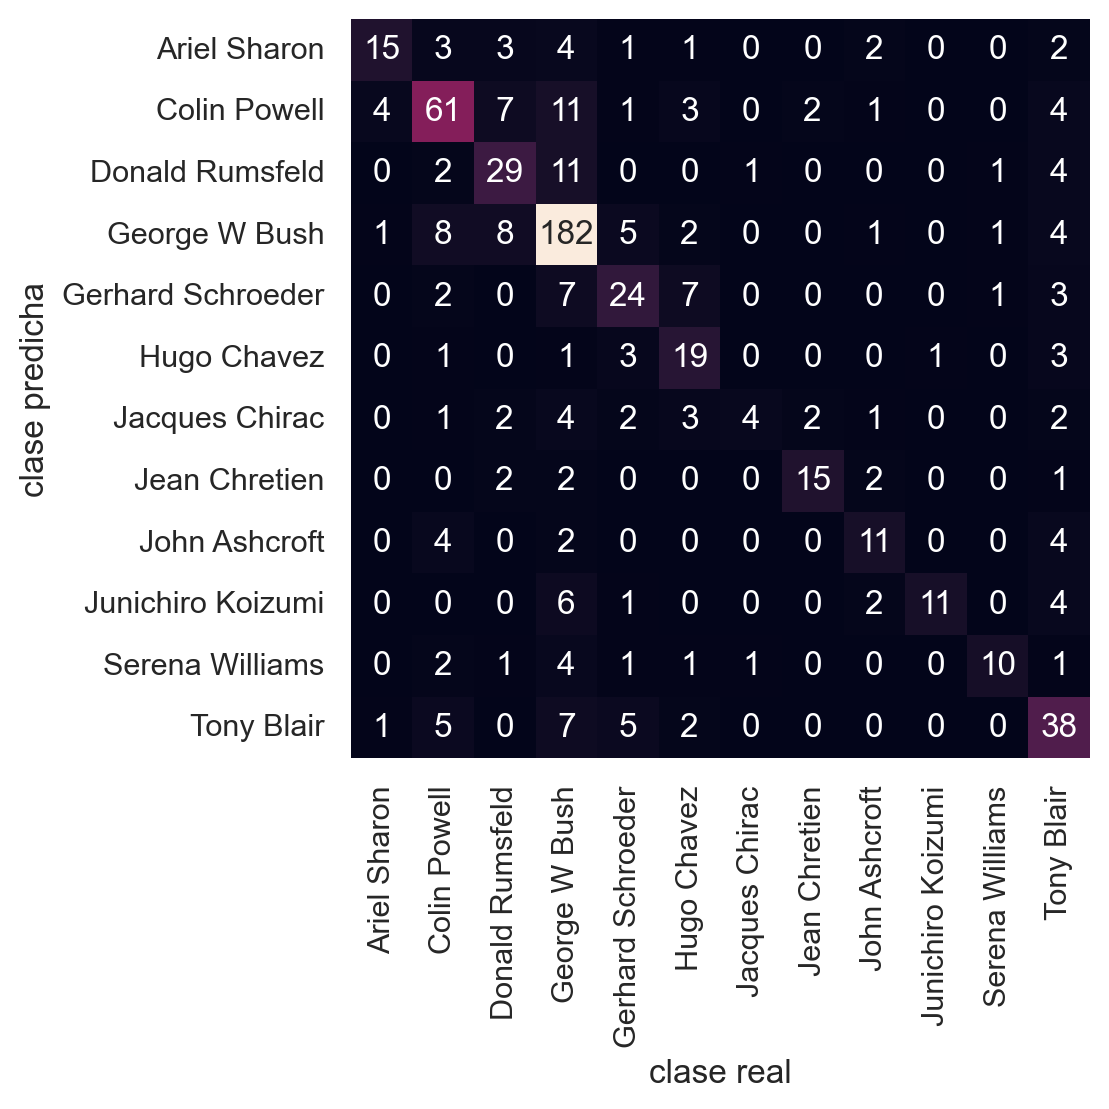

In [77]:
##################
# YOUR CODE 
##################
print("Score with the test data R^2={0:.4f}".format(grid_search.score(Xtest_lda, ytest)))
y_pred_test_pipeline = grid_search.predict(Xtest_lda)
mat_conf = metrics.confusion_matrix(y_pred_test_pipeline, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

## 7.2. Kernel PCA + SVM lineal

La segunda combinación emplea el Kernel PCA como extractor de características y la SVM lineal como etapa de clasificación alimentada por las características que suministra el KPCA. Para evaluar este método:
1. Programad una pipeline con una primera etapa que sea el KPCA con un kernel RBF y una segunda etapa que sea una SVM lineal
2. Obtened mediante validación cruzada los mejores parámetros para el KPCA y para la SVM:
    - `gamma` al menos 1e-10,1e-9, 1e-8, 1e-7, 1e-6
    - número de componentes: al menos 50,100,200,500,1000
    - `C` al menos 0.1, 1, 10, 100, 1000, 

In [86]:
##################
# YOUR CODE 
##################
pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('svm', svm.SVC(kernel='linear'))
])
param_grid = {
    'kpca__gamma': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6],
    'kpca__n_components': [50, 100, 200, 500, 1000],
    'svm__C': [0.1, 1, 10, 100, 1000]
}

grid_search_kpca_svm = GridSearchCV(pipeline, param_grid, cv=3)
grid_search_kpca_svm.fit(Xtrain, ytrain)

C:\Users\yajai\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yajai\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yajai\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\yajai\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\yajai\Anacond

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(kernel='rbf')),
                                       ('svm', SVC(kernel='linear'))]),
             param_grid={'kpca__gamma': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06],
                         'kpca__n_components': [50, 100, 200, 500, 1000],
                         'svm__C': [0.1, 1, 10, 100, 1000]})

**Imprimid el score alcanzado en el conjunto de test y la matriz de confusión para este clasificador KPCA + SVM lineal**

Score with the test data R^2=0.4167


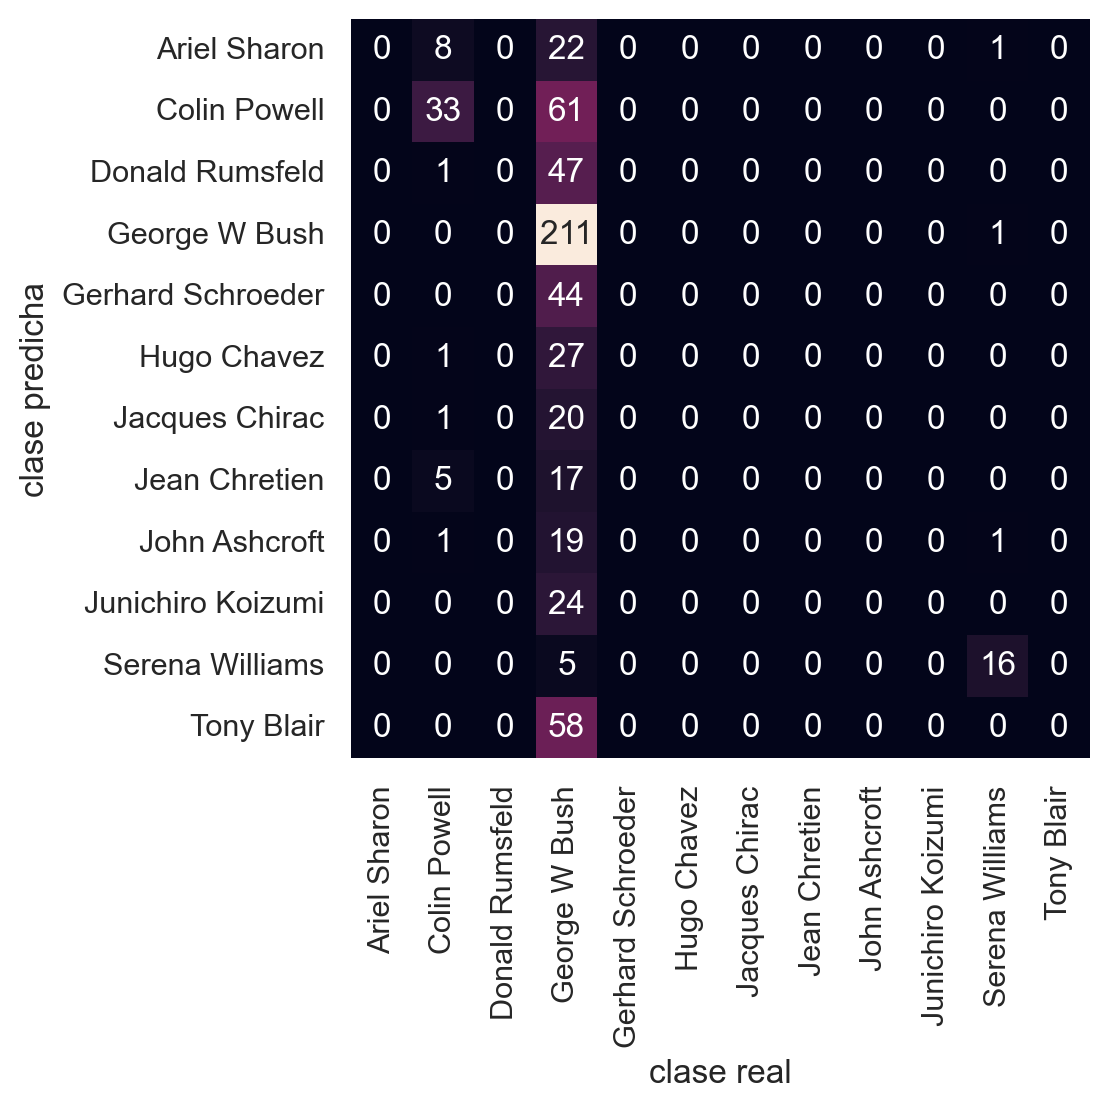

In [87]:
##################
# YOUR CODE 
##################
print("Score with the test data R^2={0:.4f}".format(grid_search_kpca_svm.score(Xtest, ytest)))
y_pred_test_pipeline = grid_search_kpca_svm.predict(Xtest)
mat_conf = metrics.confusion_matrix(y_pred_test_pipeline, ytest) # código que calcula la matriz de confusión para el conjunto de test

sns.heatmap(mat_conf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('clase real')
plt.ylabel('clase predicha');

**¿Cómo comparan los resultados obtenidos con KPCA + SVM lineal con los que se obtienen con PCA + SVM no lineal?**

# 8. Prestaciones con el conjunto de entrenamiento contaminado con ruido (20%)

La siguente celda añade ruido al conjunto de entrenamiento. Inicialmente vamos a estudiar el efecto de añadir ruido Gaussiano de media nula y desviación típica 50 (los datos no están escalados), pero si tenéis tiempo podéis explorar lo que ocurre si variamos este parámetro nivel de ruido.

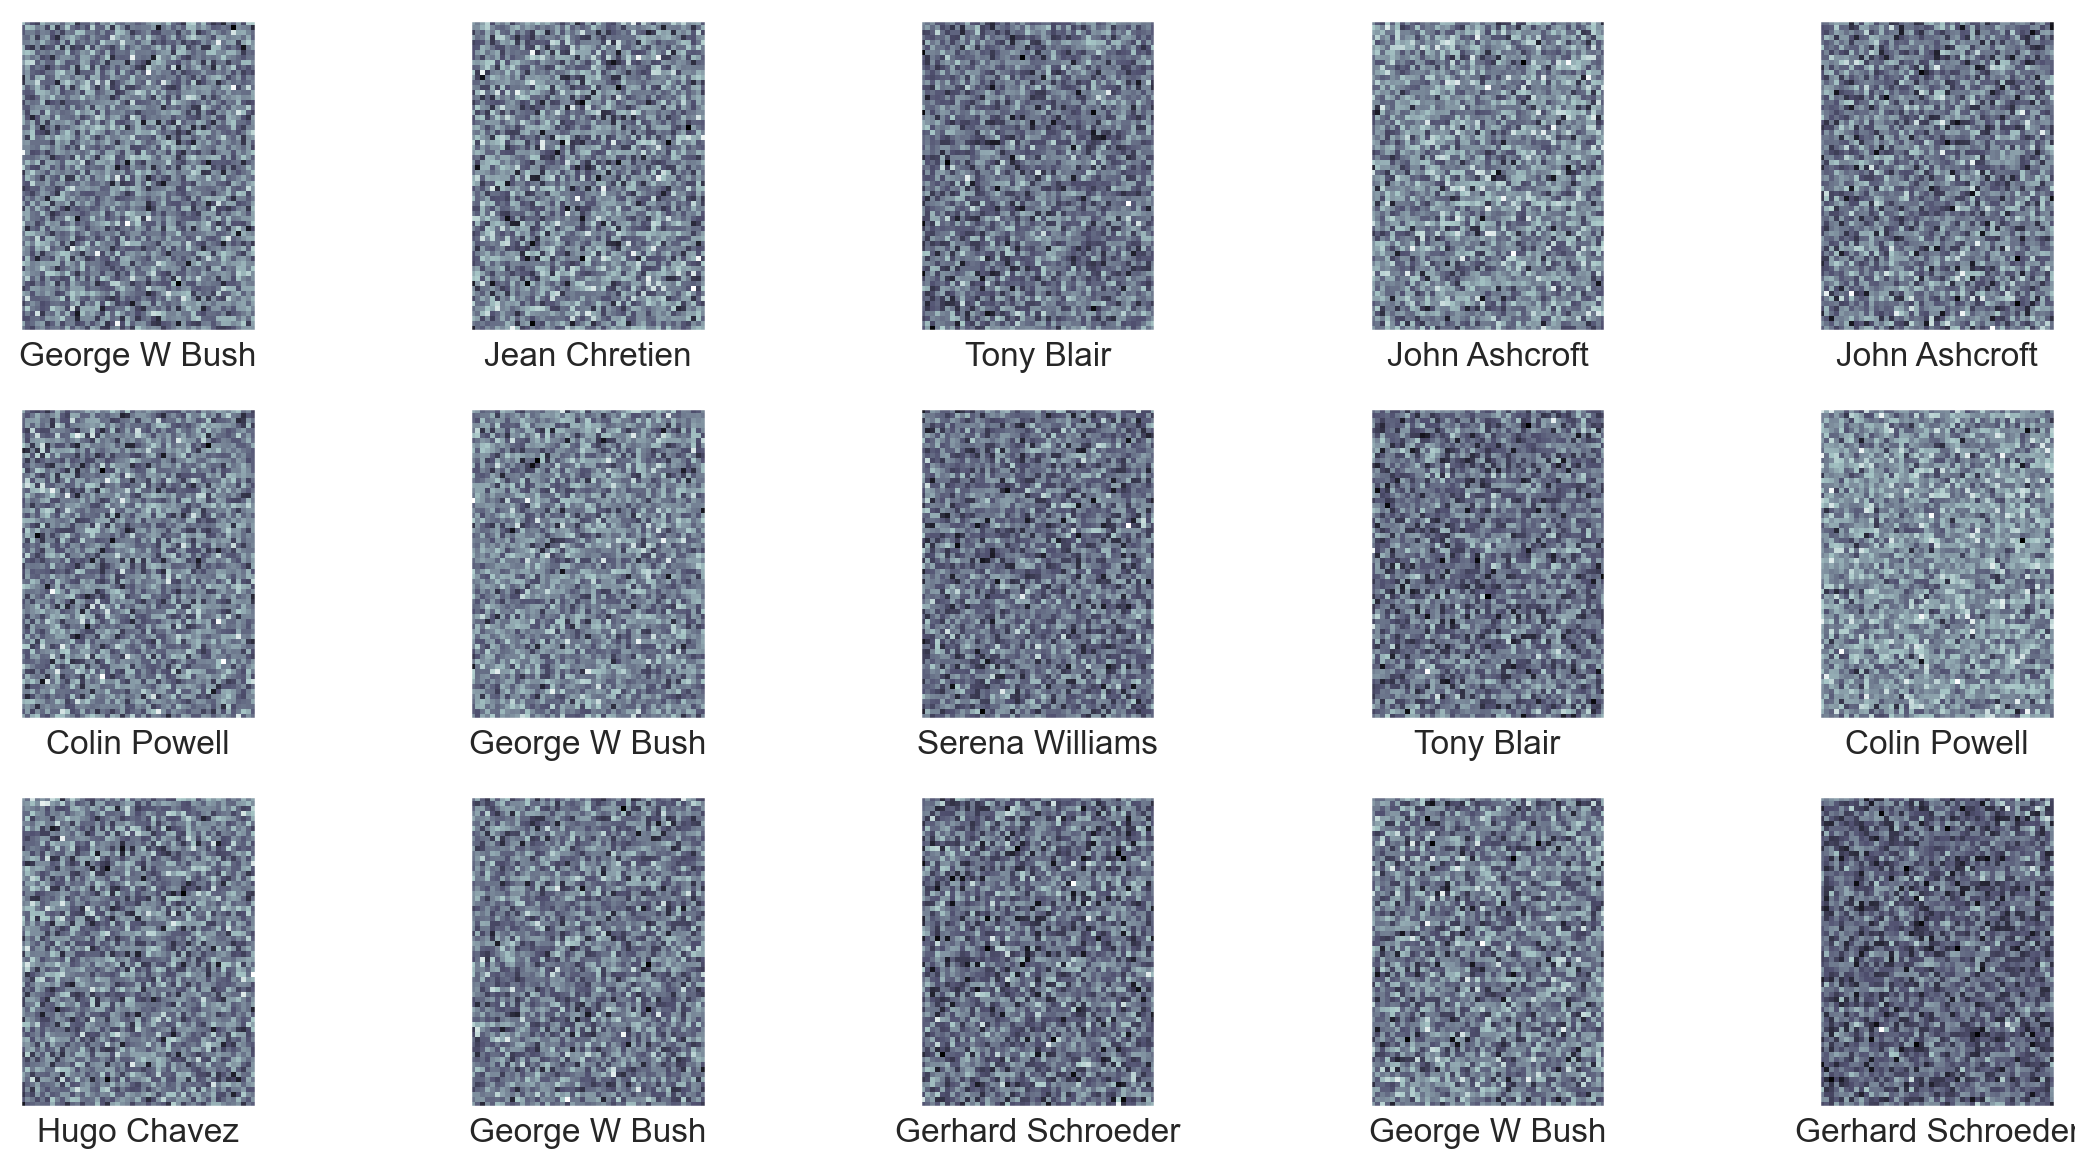

In [88]:
nivel_de_ruido = 50 # desviación típica del ruido Gaussiano de media nula
ruido = np.random.normal(scale=nivel_de_ruido, size=Xtrain.shape)
Xtrain_ruido = Xtrain + ruido
fig, ax = plt.subplots(3, 5, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtrain_ruido[i].reshape(62,47), cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[ytrain[i]])
fig.tight_layout()

Vamos a analizar cuál de estas 3 estrategias es más robusta frente al ruido:

1. SVM sobre los datos de entrada originales
   
2. PCA + LDA

3. KPCA + LDA

Para ello entrene y evalúe los clasificadores (o pipelines, según sea el caso) correspondientes en las mismas condiciones que en las secciones anteriores pero usando `Xtrain_ruido` en lugar de `Xtrain`.

In [89]:
# 8.1 SVM

##################
# YOUR CODE 
##################

from sklearn.model_selection import GridSearchCV
from sklearn import svm

v_C = [0.01, 0.1, 1, 10, 100, 1000]
v_gamma = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
svm_params = [{'kernel':['linear']
              ,'C':v_C
             }
              ,{'kernel':['rbf']
              ,'C':v_C
              ,'gamma' : v_gamma
             }]

grid_svm = GridSearchCV(svm.SVC(), param_grid=svm_params, cv=3, verbose=2, n_jobs=-1)
grid_svm.fit(Xtrain_ruido, ytrain)
print("Score with the test data R^2={0:.4f}".format(grid_svm.score(Xtest, ytest)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Score with the test data R^2=0.3397


In [90]:
## 8.2 PCA + SVM

##################
# YOUR CODE 
##################
from sklearn.pipeline import Pipeline

valores = [50,100,150]
for i in valores :
    pipeline = Pipeline([
        ('n_first', n_first_cols(n_components=i)),
        ('svm', svm.SVC(kernel='rbf'))
    ])
    param_grid = {
        'svm__gamma': [1e-9, 1e-8, 1e-7, 1e-6],
        'svm__C': [0.1, 1, 10, 100, 1000]}

    grid_search_pca_svm = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search_pca_svm.fit(Xtrain_ruido, ytrain)
    print("Score with the test data R^2={0:.4f}".format(grid_search_pca_svm.score(Xtest, ytest)))

Score with the test data R^2=0.3397
Score with the test data R^2=0.3397
Score with the test data R^2=0.3397


In [93]:
## 8.3 KPCA - LDA

##################
# YOUR CODE 
##################

from sklearn.decomposition import KernelPCA
pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'kpca__gamma': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6],
    'kpca__n_components': [50, 100, 200, 500, 1000]
}

grid_search_kpca_lda = GridSearchCV(pipeline, param_grid, cv=3)
grid_search_kpca_lda.fit(Xtrain_ruido, ytrain)
print(grid_search_kpca_lda.best_params_)
print("Score with the test data R^2={0:.4f}".format(grid_search_kpca_lda.score(Xtest, ytest)))

{'kpca__gamma': 1e-10, 'kpca__n_components': 50}
Score with the test data R^2=0.3397


**¿Cuál es la estrategia que da mejores prestaciones en presencia de ruido?** **¿Cuál es la que menos se degrada por la presencia de ruido?**
**El PCA y el KPCA, seleccionan más o menos componentes cuando hay ruido en los datos o cuando no hay ruido?**